<a href="https://colab.research.google.com/github/jayc279/collab/blob/main/fashion_mnist_conv_5_stack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# drive.flush_and_unmount()
# !ls /content/drive/MyDrive/colab_work/

Mounted at /content/drive/
drive  sample_data


In [2]:
# !pip install -U -q kaggle
# !mkdir -p ~/.kaggle

# %cd gdrive/MyDrive/colab_work
# !cp kaggle.json ~/.kaggle

In [3]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Dropout, BatchNormalization, Input
from keras.layers import MaxPooling2D, Embedding
from keras.models import Model, Sequential
from keras.layers import ReLU, LeakyReLU, ELU, Softmax
from keras.layers.experimental import preprocessing

In [4]:
from keras.datasets import mnist, fashion_mnist
from keras.optimizers import Adam, RMSprop
from keras.callbacks import Callback

In [5]:
mnist_data = mnist.load_data()

In [6]:
type(mnist_data)

tuple

In [7]:
fashion_data =  fashion_mnist.load_data()

In [8]:
(train_images, train_labels), (test_images, test_labels) = fashion_data

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
train_images = (train_images/255).astype(np.float32)
test_images = (test_images/255).astype(np.float32)

In [12]:
from skimage.transform import resize
img = train_images[10]
img_resized = resize(img, (3, 3))

(3, 3)


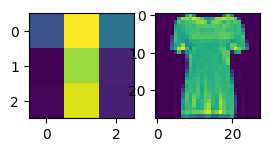

In [13]:
print(img_resized.shape)

plt.figure(figsize=(3,3))
plt.subplot(2,2,1)
plt.imshow(img_resized)
plt.subplot(2,2,2)
plt.imshow(img)

In [14]:
train_labels.max(), train_labels.min()
from keras.utils import to_categorical
num_cats = train_labels.max() + 1
print(num_cats)
train_labels = to_categorical(train_labels, num_classes=num_cats)
test_labels = to_categorical(test_labels, num_classes=num_cats)

10


In [15]:
train_labels[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [16]:
train_images.shape, train_images.shape[2]
print(test_labels[:2])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

In [18]:
print(test_images.shape, train_images.shape)

(10000, 28, 28, 1) (60000, 28, 28, 1)


In [19]:
from sklearn.model_selection import train_test_split
(X_val, X_test, y_val, y_test) = train_test_split(test_images, test_labels, random_state=1, shuffle=True, test_size=0.5)

In [20]:
from os import EX_PROTOCOL
def create_model(inp):
  keras.backend.clear_session()
  model_in = Input(shape=(inp.shape[1], inp.shape[2], 1))

  # block1
  layer1 = Conv2D(512, kernel_size=(3,3), strides=1, padding='same')(model_in)
  act1 = ReLU()(layer1)
  max1 = MaxPooling2D(pool_size=(2,2))(act1)

  # block2
  layer2 = Conv2D(512, kernel_size=(3,3), strides=1, padding='same')(max1)
  act2 = ReLU()(layer2)
  max2 = MaxPooling2D(pool_size=(2,2))(act2)
  batch1 = BatchNormalization(momentum=0.98, epsilon=0.002)(max2)

  # block3
  layer3 = Conv2D(256, kernel_size=(3,3), strides=1, padding='same')(batch1)
  act3 = ReLU()(layer3)
  max3 = MaxPooling2D(pool_size=(2,2))(act3)

# block4
  layer4 = Conv2D(256, kernel_size=(3,3), strides=1, padding='same')(max3)
  act4 = ReLU()(layer4)
  max4 = MaxPooling2D(pool_size=(2,2))(act4)
  # flat1 = Flatten()(max4)

  batch2 = BatchNormalization(momentum=0.98, epsilon=0.002)(max4)
  flat1 = Flatten()(batch2)

  dense1 = Dense(512, activation='relu')(flat1)
  drop1 = Dropout(0.4)(dense1)
  dense2 = Dense(256, activation='relu')(drop1)
  dense3 = Dense(256, activation='relu')(dense2)

  dense4 = Dense(128, activation='relu')(dense3)
  # drop2 = Dropout(0.4)(dense3)
  # dense41 = Dense(128, activation='relu')(drop2)

  dense5 = Dense(64, activation='relu')(dense4)
  out = Dense(num_cats, activation='softmax')(dense5)

  model = Model(model_in, out)

  return model


In [21]:
# directories on Google Drive to save models, weights, logs
tensor_log_dir = '/content/drive/MyDrive/colab_work/logs'
checkpoint_keras_filepath = '/content/drive/MyDrive/colab_work/backup/mnist.keras'
checkpoint_weights_filepath = '/content/drive/MyDrive/colab_work/backup/mnist.weights.h5'
model_backup_dir = '/content/drive/MyDrive/colab_work/backup'

In [22]:
# Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensor_log_dir,
                                                   update_freq='epoch',
                                                   )

In [23]:
# backup -an- restore
call_restore = keras.callbacks.BackupAndRestore(backup_dir=model_backup_dir)

In [24]:
# keras.callbacks.ModelCheckpoint
checkpoint_model_save = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_keras_filepath,   # where to save - is it a file or directory - it must end in .keras
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

checkpoint_weights_save = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_weights_filepath,           # where to save - is it a file or directory - must end in .weights.h5
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# The model (that are considered the best) can be loaded as -
# keras.models.load_model(checkpoint_filepath)

In [25]:
# create callbacks
callback = keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta = 0.2,
    patience=3,
    verbose=1,
    restore_best_weights = False,
    start_from_epoch=20
)

In [26]:
class CustomCallBacks(Callback):
  def on_epoch_end(self, epoch, logs=None):
    keys = list(logs.keys())
    # print(f'End of Epoch: {epoch} - keys:{keys}')
    print(f'End of Epoch: {epoch}', end=" ")

In [27]:
minst_model = create_model(train_images)
minst_model.summary()
minst_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.002, beta_1=0.5), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 512)       5120      
                                                                 
 re_lu (ReLU)                (None, 28, 28, 512)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 512)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 512)       2359808   
                                                                 
 re_lu_1 (ReLU)              (None, 14, 14, 512)       0         
                                                             

In [ ]:
history = minst_model.fit(train_images, train_labels,
                          epochs=50, batch_size=32,
                          callbacks=[callback, call_restore,
                                     checkpoint_model_save,checkpoint_weights_save,
                                     tensorboard_callback, CustomCallBacks()],
                          validation_data=([X_val, y_val]),
                          verbose=2)

Epoch 1/50
End of Epoch: 0 1875/1875 - 56s - loss: 0.5061 - accuracy: 0.8213 - val_loss: 0.3844 - val_accuracy: 0.8668 - 56s/epoch - 30ms/step
Epoch 2/50
End of Epoch: 1 1875/1875 - 37s - loss: 0.3336 - accuracy: 0.8836 - val_loss: 0.3331 - val_accuracy: 0.8776 - 37s/epoch - 20ms/step
Epoch 3/50
End of Epoch: 2 1875/1875 - 38s - loss: 0.3028 - accuracy: 0.8952 - val_loss: 0.2799 - val_accuracy: 0.9016 - 38s/epoch - 20ms/step
Epoch 4/50
End of Epoch: 3 1875/1875 - 36s - loss: 0.2603 - accuracy: 0.9105 - val_loss: 0.3212 - val_accuracy: 0.8904 - 36s/epoch - 19ms/step
Epoch 5/50
End of Epoch: 4 1875/1875 - 38s - loss: 0.2458 - accuracy: 0.9141 - val_loss: 0.4059 - val_accuracy: 0.8830 - 38s/epoch - 20ms/step
Epoch 6/50
End of Epoch: 5 1875/1875 - 39s - loss: 0.2353 - accuracy: 0.9215 - val_loss: 0.2804 - val_accuracy: 0.9030 - 39s/epoch - 21ms/step
Epoch 7/50
End of Epoch: 6 1875/1875 - 39s - loss: 0.2138 - accuracy: 0.9269 - val_loss: 0.2573 - val_accuracy: 0.9160 - 39s/epoch - 21ms/step

In [ ]:
model_eval = minst_model.evaluate(X_val, y_val, verbose=2)

In [ ]:
predictions = minst_model.predict(X_test)

In [ ]:
hist_frame = pd.DataFrame(history.history)
sns.lineplot(data=hist_frame.loc[:,['loss', 'val_loss']])

In [ ]:
sns.lineplot(data=hist_frame.loc[:,['accuracy', 'val_accuracy']])

In [ ]:
model_eval = minst_model.evaluate(X_test, y_test, verbose=2)

In [ ]:
# convert predictions to capture actual predicted
y_predicted = np.argmax(predictions, axis=1)
y_truth = np.argmax(y_test, axis=1)
# print(y_predicted[:100])
# print(y_truth[:100])
correct_pred = len(y_truth[np.equal(y_truth, y_predicted)])
incorrect_pred = len(y_truth[~np.equal(y_truth, y_predicted)])
print('correct count; ', correct_pred)
print('incorrect count; ', incorrect_pred)
print('correct percentage=' , (correct_pred / (correct_pred + incorrect_pred))*100)
print('in-correct percentage=' , (incorrect_pred / (correct_pred + incorrect_pred))*100)

In [ ]:
y_truth[:20], y_predicted[:20]
print('# of values that do not match ground truth: ', len(y_truth[~np.equal(y_truth, y_predicted)]))

In [ ]:
# for i in range(len(y_truth[~np.equal(y_truth, y_predicted)])):
#   if i % 10 == 0:
#      print(i,':',y_predicted[i],':',y_truth[~np.equal(y_truth, y_predicted)][i], end='\n')
#   else:
#     print(i,':',y_predicted[i],':',y_truth[~np.equal(y_truth, y_predicted)][i], end=' - ')

In [ ]:
# y_truth[~np.equal(y_truth, y_predicted)]
xx = np.equal(y_truth, y_predicted)
xx_where = np.where(xx == False)

In [ ]:
# # print IDs in y_truth and y_predicted Numpy arrays where VALUEs do not match
for i in list(xx_where[0]):
  print('i:', i, '-', y_truth[i], '-', y_predicted[i])

In [ ]:
plt.figure(figsize=(3,3))
plt.subplot(2,2,1)
plt.imshow(X_test[4220])
plt.title('item 2')
plt.subplot(2,2,2)
plt.imshow(X_test[4277])
plt.title('item 4')
plt.subplot(2,2,3)
plt.imshow(X_test[4444])
plt.xlabel('item 0')
plt.subplot(2,2,4)
plt.imshow(X_test[4746])
plt.xlabel('item 6')

In [ ]:
# TensorBoard
%load_ext tensorboard
# %reload_ext tensorboard

In [ ]:
# Best to remount Goole Drive - since session may have restarted multipel time
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

In [ ]:
# don't think you will need to CD to directory, but check
# !cd /content/drive/MyDrive/colab_work/
# verfication -to make sure there ia 'logs' directory with 'Train' and 'Validation' directories
# !ls

In [ ]:
# %tensorboard --logdir tensor_log_dir